In [1]:
# Imports
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
from datetime import datetime as dt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from scipy import stats
from statistics import mean, stdev
from scipy.stats import wilcoxon, mannwhitneyu
import seaborn as sb

In [2]:
pd.set_option('display.max_columns', 1000)
df = pd.read_csv("Resultados_Ana.csv").drop(columns=['Unnamed: 0'])
df.head()

,patient_id,PARTICIPANTE,DATA_INICIO,DATA_FIM,PSQI_ESCORE_Autopercepcao da qualidade do sono,PSQI_ESCORE_latência do sono,LATÊNCIA DO SONO (EM MINUTOS QUESTÃO 2),PSQI_ESCORE_DURAÇÃO DO SONO,DURAÇÃO DO SONO (EM HORAS QUESTÃO 4),PSQI_ESCORE_EFICIÊNCIA HABITUAL DO SONO,EFICIÊNCIA HABITUAL DO SONO (%),PSQI_ESCORE_DISTÚRBIOS DE SONO,PSQI_ESCORE_USO DE MEDICACAO PARA DORMIR,PSQI_ESCORE_DISFUNÇÃO DURANTE O DIA),PSQI_ESCORE_GLOBAL_CLASSIFICACAO,duration_minutes,duration_classification,efficiency in %,efficiency_classification,latency_minutes,latency_classification
0,618aaae0d068f5001c785795,MARIA DE LOURDES SANTOS FREITAS,18/11/2021,24/11/2021,1,2,20,0,8,3,60,1,2,0,9,316.0,2.0,94.0,0.0,4.0,0.0
1,619d06aa1913dc00199e6892,EDINEUZA MARIA BARBOSA,18/11/2021,25/11/2021,1,3,60,0,8,0,100,2,3,0,9,468.0,0.0,91.0,0.0,6.0,0.0
2,61ae05201913dc00199e9d40,LÚCIA DE FÁTIMA BATISTA,02/12/2021,09/12/2021,2,2,30,1,6,2,66,1,0,3,12,303.0,2.0,93.0,0.0,5.0,0.0
3,61ae09341913dc00199e9db4,MARIA DAS GRAÇAS FERREIRA,02/12/2021,09/12/2021,1,1,30,1,6,0,"85,75",1,0,2,6,327.0,2.0,93.0,0.0,6.0,0.0
4,61ae08451913dc00199e9d75,GETULIO BATISTA DE ALMEIDA,02/12/2021,09/12/2021,1,2,30,0,8,0,"88,8",2,0,0,5,431.0,0.0,91.0,0.0,5.0,0.0


In [3]:
df['qualidade_sono'] = df['PSQI_ESCORE_Autopercepcao da qualidade do sono'] + df['latency_classification'] + df['duration_classification'] + df['efficiency_classification'] + df['PSQI_ESCORE_DISTÚRBIOS DE SONO'] + df['PSQI_ESCORE_USO DE MEDICACAO PARA DORMIR'] + df['PSQI_ESCORE_DISFUNÇÃO DURANTE O DIA)']
df['qualidade_sono_classification'] = np.where(df['qualidade_sono'] >10, 'presença de distúrbio do sono', 'ruim')
df['qualidade_sono_classification'] = np.where(df['qualidade_sono'] <= 4, 'boa', df['qualidade_sono_classification'])
df.qualidade_sono_classification.value_counts()

ruim                             36
boa                              14
presença de distúrbio do sono     2
Name: qualidade_sono_classification, dtype: int64

In [4]:
df['qualidade_sono_classification_psqi'] = np.where(df['PSQI_ESCORE_GLOBAL_CLASSIFICACAO'] >10, 'presença de distúrbio do sono', 'ruim')
df['qualidade_sono_classification_psqi'] = np.where(df['PSQI_ESCORE_GLOBAL_CLASSIFICACAO'] <= 4, 'boa', df['qualidade_sono_classification_psqi'])
df.qualidade_sono_classification_psqi.value_counts()

ruim                             31
presença de distúrbio do sono    15
boa                               6
Name: qualidade_sono_classification_psqi, dtype: int64


#### OBJETIVOS TRABALHO

* Correlacionar os parâmetros objetivos do sono (tempo total, letência e eficiência do sono) obtidos pelo dispositivo smartwatch e pela escala subjetiva PSQI);
* Investigar a associação da autopercepção da qualidade do sono (domínio 1) com características do sono obtidas pelo dispositivo (tempo total, letência, eficiência, estágios de sono e despertares noturnos);
* Associar a eficiência do sono medida pelo dispositivo com o escore total do PSQI.

#### ANÁLISE DOS DADOS (como eu sugeri no projeto de qualificação, pode alterar)

* Para a análise das variáveis contínuas será aplicado o teste de Kolmogov-Smirnov e análise do gráfico Q-Q para examinar a normalidade dos dados.
* Para a comparação dos dados contínuos entre os dois grupos (De acordo com seu escore no IQSP: grupo qualidade de sono boa (<5) e grupo qualidade de sono ruim (>5) será utilizado o Teste t de Student (distribuição normal) para amostras independentes e/ou teste de Mann-Whitney (distribuição anormal), enquanto que a comparação dos dados categóricos será analisada pelo teste do χ2.
* As correlações das variáveis contínuas serão avaliadas utilizado os coeficientes de correlação de Pearson ou Spearman (a depender da normalidade da distribuição dos dados).
* Para analisar a correlação entre a autopercepção do sono e variáveis do sono medidas pelo dispositivo, será realizado o Teste de Correlação de Spearman.
* Para avaliar a concordância entre os métodos (objetivo e subjetivo) será realizada a análise gráfica de Bland e Altman.


In [5]:
df_sono_bom = df[df.PSQI_ESCORE_GLOBAL_CLASSIFICACAO < 5.0]

In [6]:
df_sono_ruim = df[df.PSQI_ESCORE_GLOBAL_CLASSIFICACAO >= 5.0]

### Normalidade (Teste KS e QQ-Plot)

In [7]:
def cdf(sample, x, sort = False):
    if sort:
        sample.sort()
    cdf = sum(sample <= x)
    cdf = cdf / len(sample)
    return cdf

In [8]:
def ks_norm(sample):
    sample.sort()
    D_ks = []
    for x in sample:
        cdf_normal = stats.norm.cdf(x = x, loc = 0, scale = 1)
        cdf_sample = cdf(sample = sample, x  = x)
        D_ks.append(abs(cdf_normal - cdf_sample))
    ks_stat = max(D_ks)
    p_value = stats.kstwo.sf(ks_stat, len(sample))
    return {"ks_stat": ks_stat, "p_value" : p_value}

#### Sono bom

In [9]:
ks_norm_a = ks_norm(df_sono_bom.qualidade_sono.values)
print(f"norm_a: ks = {ks_norm_a['ks_stat']:.4f} (p-value = {ks_norm_a['p_value']:.3e}, is normal = {ks_norm_a['p_value'] > 0.05})")

norm_a: ks = 0.8106 (p-value = 9.243e-05, is normal = False)


In [10]:
ks_norm_a = ks_norm(df_sono_bom.PSQI_ESCORE_GLOBAL_CLASSIFICACAO.values)
print(f"norm_a: ks = {ks_norm_a['ks_stat']:.4f} (p-value = {ks_norm_a['p_value']:.3e}, is normal = {ks_norm_a['p_value'] > 0.05})")

norm_a: ks = 0.6747 (p-value = 3.185e-03, is normal = False)


Text(0.5, 1.0, 'Q-Q Plot')

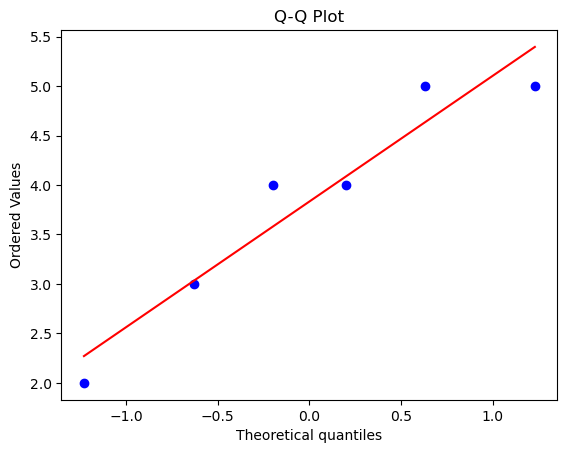

In [11]:
stats.probplot(df_sono_bom.qualidade_sono, dist="norm", plot=plt)
plt.title("Q-Q Plot")

Text(0.5, 1.0, 'Q-Q Plot')

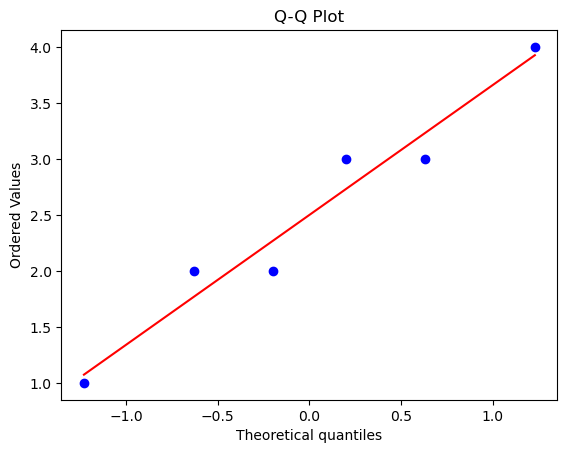

In [12]:
stats.probplot(df_sono_bom.PSQI_ESCORE_GLOBAL_CLASSIFICACAO, dist="norm", plot=plt)
plt.title("Q-Q Plot")

#### Sono ruim

In [13]:
ks_norm_a = ks_norm(df_sono_ruim.qualidade_sono.values)
print(f"norm_a: ks = {ks_norm_a['ks_stat']:.4f} (p-value = {ks_norm_a['p_value']:.3e}, is normal = {ks_norm_a['p_value'] > 0.05})")

norm_a: ks = 0.9338 (p-value = 1.172e-54, is normal = False)


In [14]:
ks_norm_a = ks_norm(df_sono_ruim.PSQI_ESCORE_GLOBAL_CLASSIFICACAO.values)
print(f"norm_a: ks = {ks_norm_a['ks_stat']:.4f} (p-value = {ks_norm_a['p_value']:.3e}, is normal = {ks_norm_a['p_value'] > 0.05})")

norm_a: ks = 0.8913 (p-value = 9.417e-45, is normal = False)


Text(0.5, 1.0, 'Q-Q Plot')

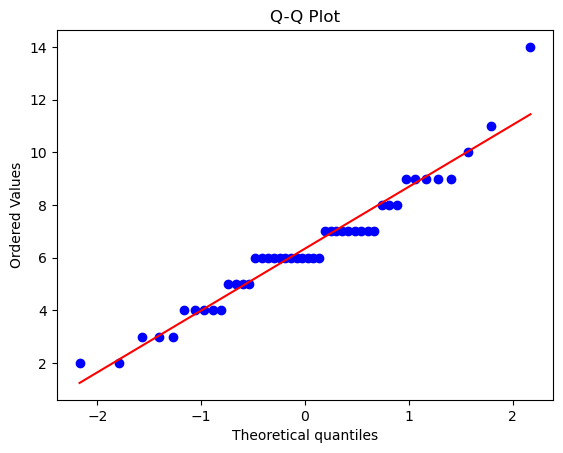

In [15]:
stats.probplot(df_sono_ruim.qualidade_sono, dist="norm", plot=plt)
plt.title("Q-Q Plot")

Text(0.5, 1.0, 'Q-Q Plot')

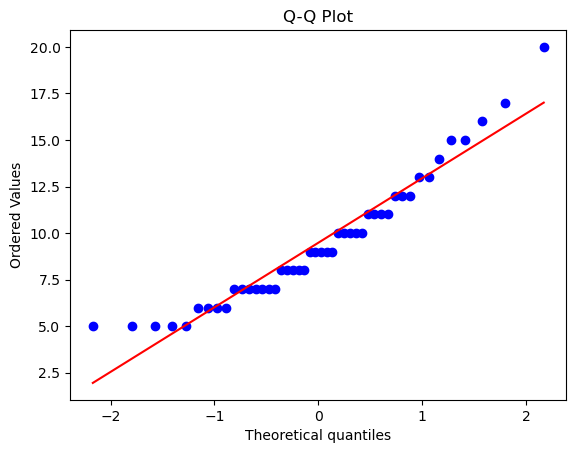

In [16]:
stats.probplot(df_sono_ruim.PSQI_ESCORE_GLOBAL_CLASSIFICACAO, dist="norm", plot=plt)
plt.title("Q-Q Plot")

### Mann-Whitney

In [17]:
mannwhitneyu(df_sono_bom.PSQI_ESCORE_GLOBAL_CLASSIFICACAO.values, df_sono_bom.qualidade_sono.values, method = 'exact')

MannwhitneyuResult(statistic=7.0, pvalue=0.09307359307359307)

In [18]:
mannwhitneyu(df_sono_ruim.PSQI_ESCORE_GLOBAL_CLASSIFICACAO.values, df_sono_ruim.qualidade_sono.values)

MannwhitneyuResult(statistic=1634.5, pvalue=5.905386880735526e-06)

### Correlograma

<AxesSubplot:>

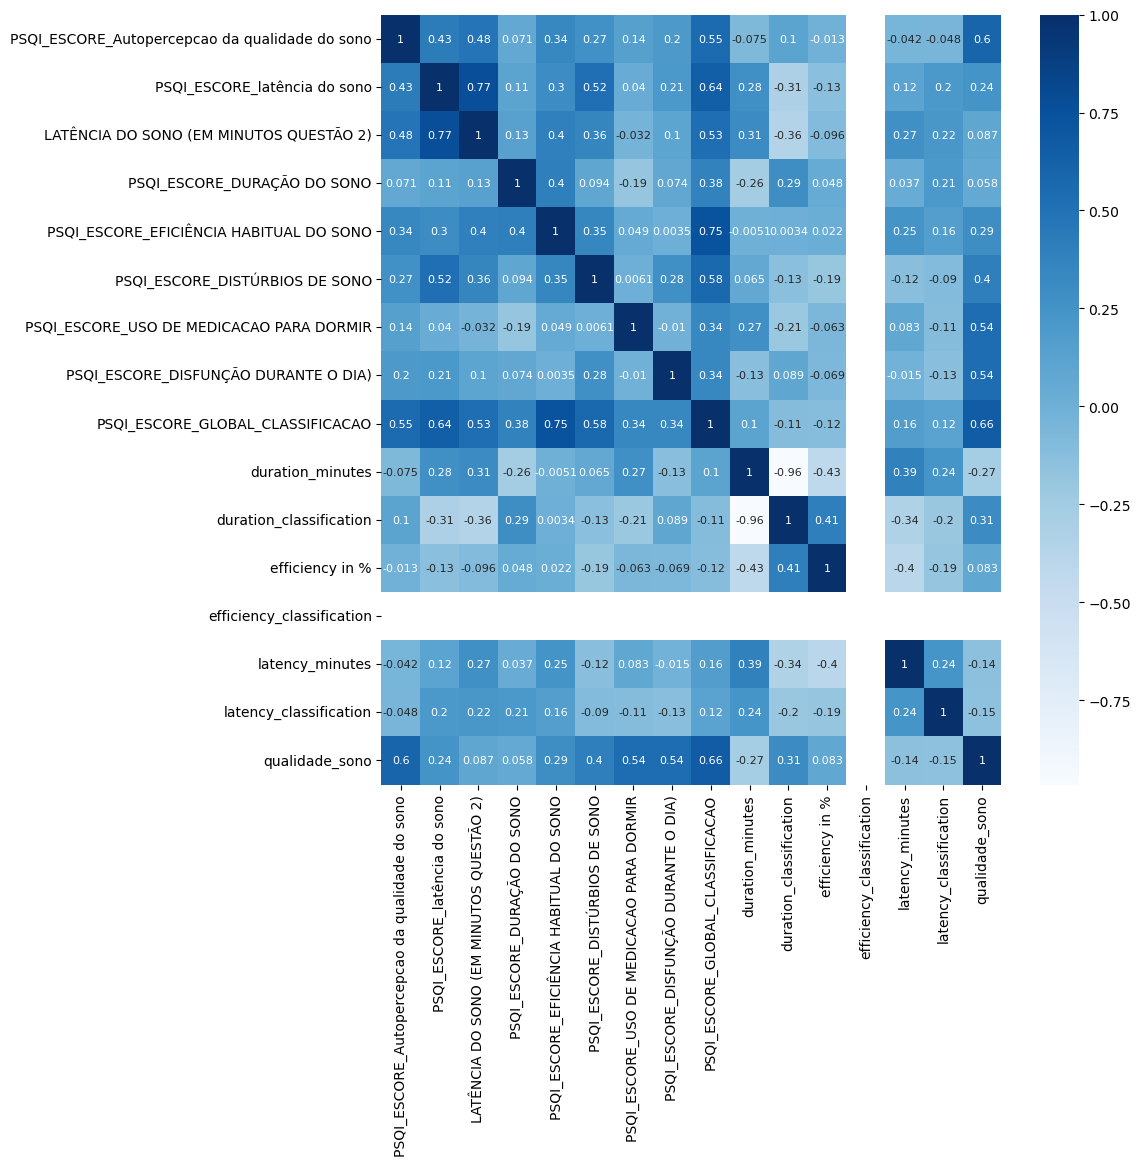

In [22]:
fig, ax = plt.subplots(figsize=(10,10))  
sb.heatmap(df.corr(method="spearman"), cmap='Blues', annot=True, ax=ax, annot_kws={"size": 8})

<AxesSubplot:>

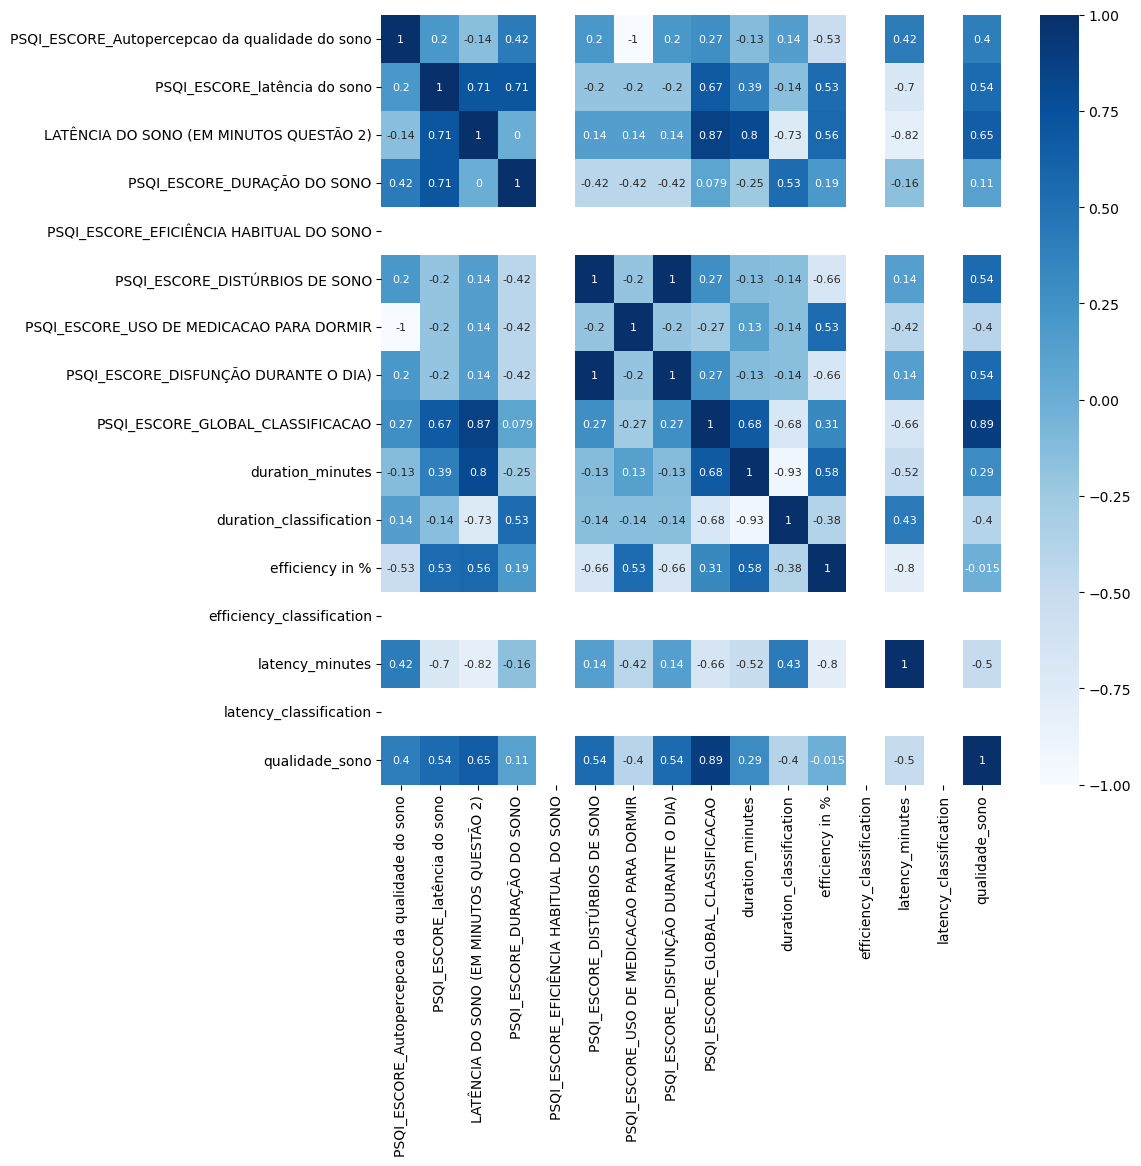

In [23]:
fig, ax = plt.subplots(figsize=(10,10))  
sb.heatmap(df_sono_bom.corr(method="spearman"), cmap='Blues', annot=True, ax=ax, annot_kws={"size": 8})

<AxesSubplot:>

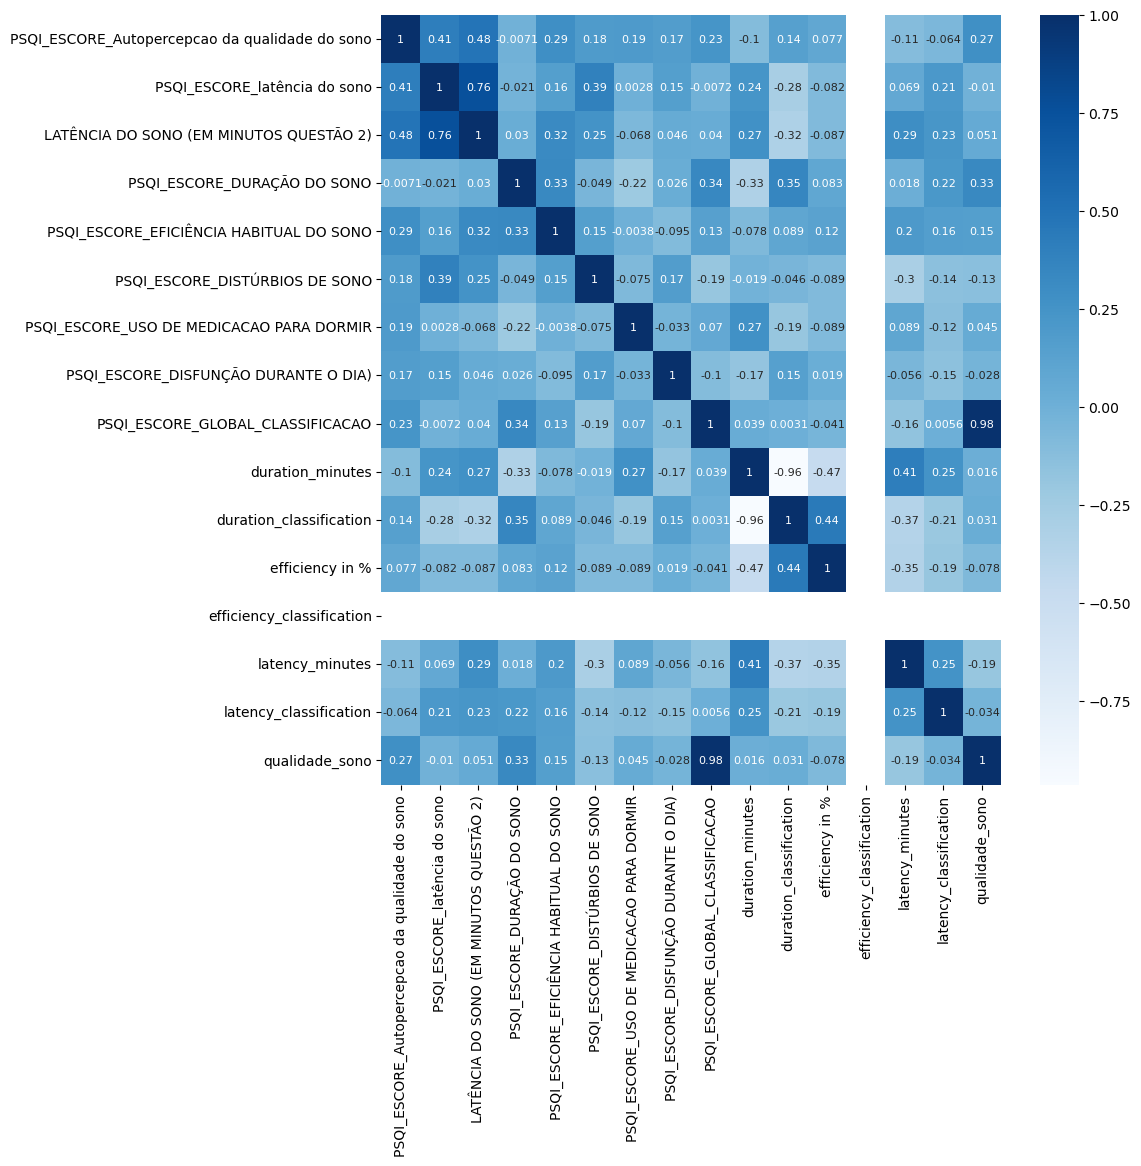

In [24]:
fig, ax = plt.subplots(figsize=(10,10))  
sb.heatmap(df_sono_ruim.corr(method="spearman"), cmap='Blues', annot=True, ax=ax, annot_kws={"size": 8})

### Bland-Altman

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   
    md        = np.mean(diff)                   
    sd        = np.std(diff, axis=0)            
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='black', linestyle='-')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    return md, sd, mean, CI_low, CI_high

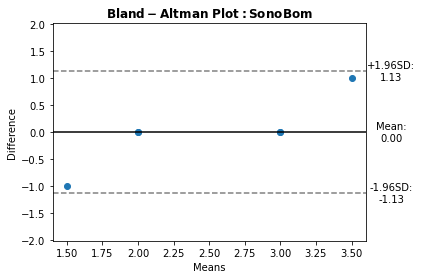

In [66]:
md, sd, mean, CI_low, CI_high = bland_altman_plot(df_sono_bom.PSQI_ESCORE_GLOBAL_CLASSIFICACAO.values, df_sono_bom.qualidade_sono.values)
plt.title(r"$\mathbf{Bland-Altman}$" + " " + r"$\mathbf{Plot: Sono Bom}$")
plt.xlabel("Means")
plt.ylabel("Difference")
plt.ylim(md - 3.5*sd, md + 3.5*sd)

xOutPlot = np.min(mean) + (np.max(mean)-np.min(mean))*1.14

plt.text(xOutPlot, md - 1.96*sd, 
    r'-1.96SD:' + "\n" + "%.2f" % CI_low, 
    ha = "center",
    va = "center",
    )
plt.text(xOutPlot, md + 1.96*sd, 
    r'+1.96SD:' + "\n" + "%.2f" % CI_high, 
    ha = "center",
    va = "center",
    )
plt.text(xOutPlot, md, 
    r'Mean:' + "\n" + "%.2f" % md, 
    ha = "center",
    va = "center",
    )
plt.subplots_adjust(right=0.85)

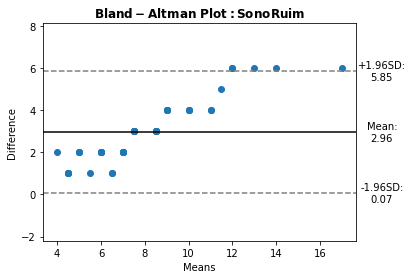

In [67]:
md, sd, mean, CI_low, CI_high = bland_altman_plot(df_sono_ruim.PSQI_ESCORE_GLOBAL_CLASSIFICACAO.values, df_sono_ruim.qualidade_sono.values)
plt.title(r"$\mathbf{Bland-Altman}$" + " " + r"$\mathbf{Plot: Sono Ruim}$")
plt.xlabel("Means")
plt.ylabel("Difference")
plt.ylim(md - 3.5*sd, md + 3.5*sd)

xOutPlot = np.min(mean) + (np.max(mean)-np.min(mean))*1.14

plt.text(xOutPlot, md - 1.96*sd, 
    r'-1.96SD:' + "\n" + "%.2f" % CI_low, 
    ha = "center",
    va = "center",
    )
plt.text(xOutPlot, md + 1.96*sd, 
    r'+1.96SD:' + "\n" + "%.2f" % CI_high, 
    ha = "center",
    va = "center",
    )
plt.text(xOutPlot, md, 
    r'Mean:' + "\n" + "%.2f" % md, 
    ha = "center",
    va = "center",
    )
plt.subplots_adjust(right=0.85)